In [2]:
import sys
from math import pi

import matplotlib.pyplot as plt
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss
from dstft import DSTFT, FDSTFT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
sr = 1e4
t = torch.arange(0, 2.5, 1/sr)
f = torch.sin(2*pi*t) * 1e2 + 1e2 * torch.ones_like(t) + 5e1 * t
x = (torch.sin(torch.cumsum(f, dim=0) / 2e2) + 0.1 *torch.randn(t.shape))[None, :]
x += torch.sin(torch.cumsum(1e2*5 * torch.ones_like(t), dim=0) / 2e2)
x = x.to(device)
print(x.shape)

torch.Size([1, 25000])


(0.0, 24999.0)

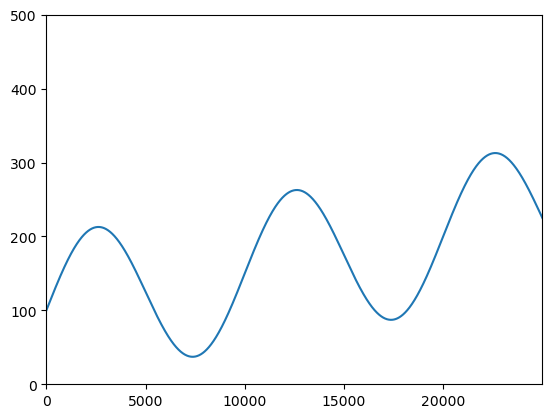

In [5]:
plt.plot(f)
plt.ylim(top=500, bottom=0)
plt.xlim(left=0, right=24999)

Text(0.5, 0, 'frames')

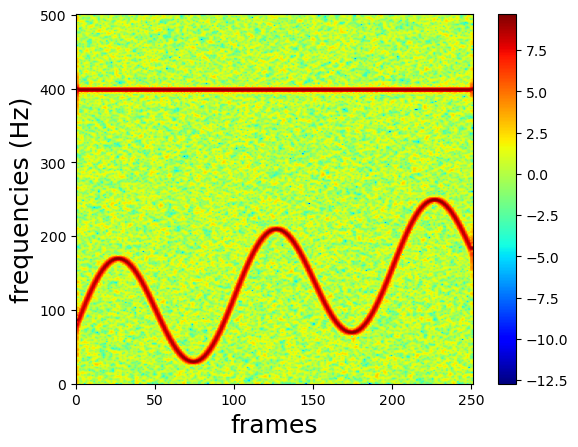

In [4]:
spec = torchaudio.transforms.Spectrogram(n_fft=1_000, win_length=500, hop_length=100)(x.cpu())
ax = plt.subplot()
im = ax.imshow(spec[0].log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
plt.colorbar(im, ax=ax)
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

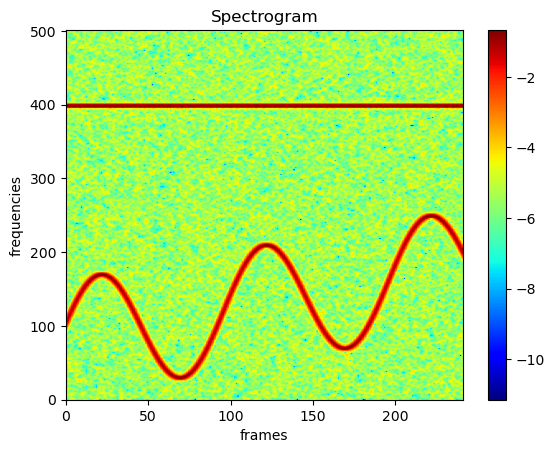

In [5]:
dstft = FDSTFT(x, win_length=500, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

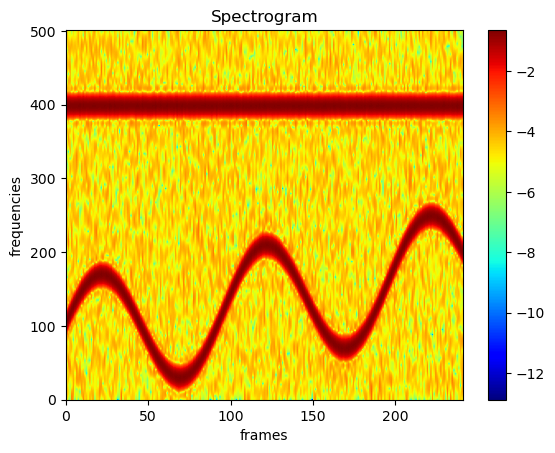

In [6]:
dstft = FDSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

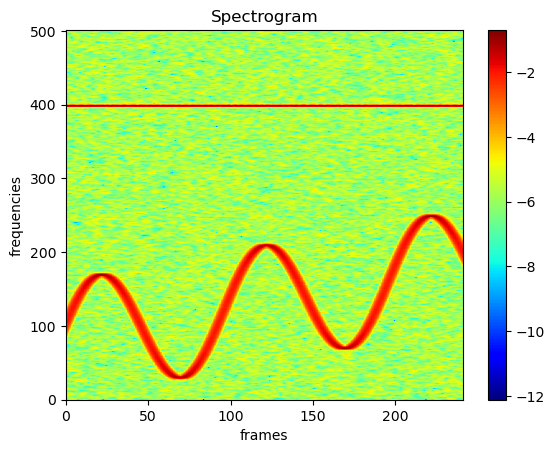

In [7]:
dstft = FDSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

Single window length

495 tensor(10.7476, device='cuda:0')


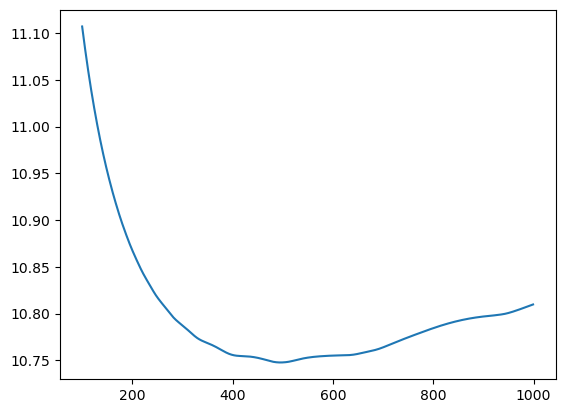

In [6]:
losses = []
min_err = 100
min_win = 0

for win_length in range(100, 1000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=1_000, stride=50, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    losses.append(err.cpu())
    
print(min_win, min_err)
plt.plot(range(100, 1000, 1), losses)

Epoch 00017: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00027: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00037: reducing learning rate of group 0 to 1.0000e-01.
36
478.6605224609375 tensor(10.0567, device='cuda:0', grad_fn=<MeanBackward0>)


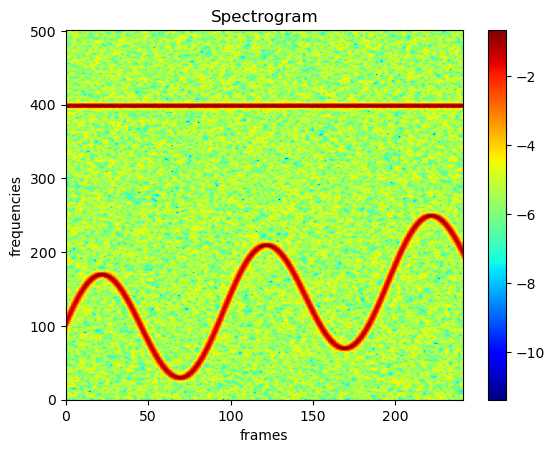

499.9


In [10]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
print(min_win, min_err)
dstft.print(spec, x, bar=True, wins=False, weights=False)
print(f'{dstft.win_length.item():.1f}')

Time-varying window length

Epoch 00024: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00035: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00045: reducing learning rate of group 0 to 1.0000e-01.
44


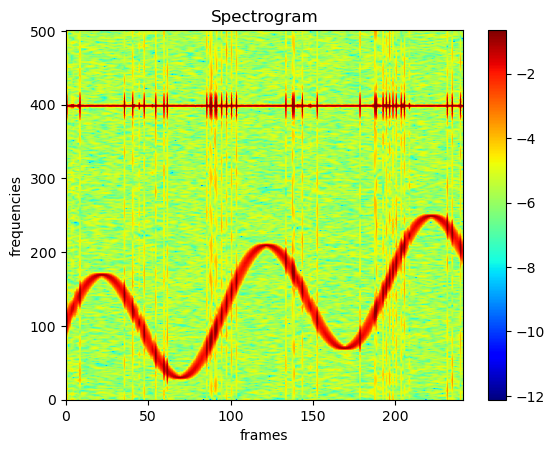

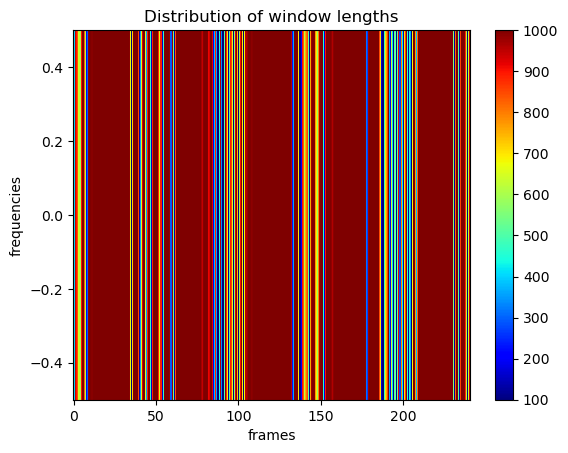

In [9]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00125: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00142: reducing learning rate of group 0 to 1.0000e-01.
141


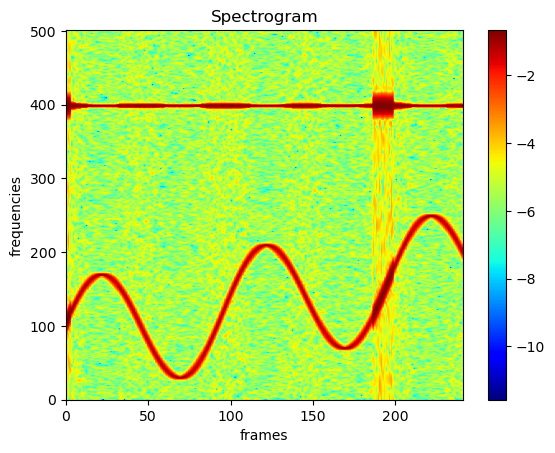

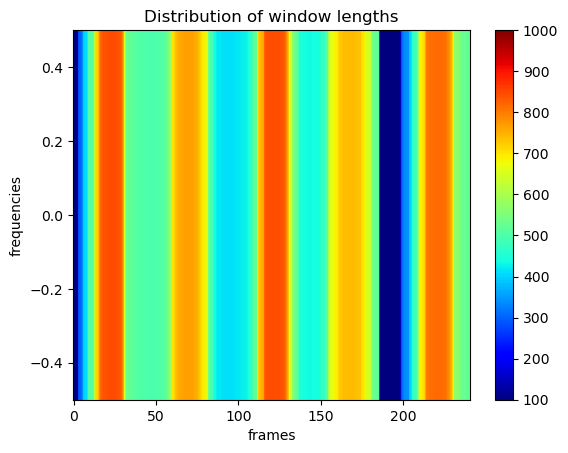

In [10]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


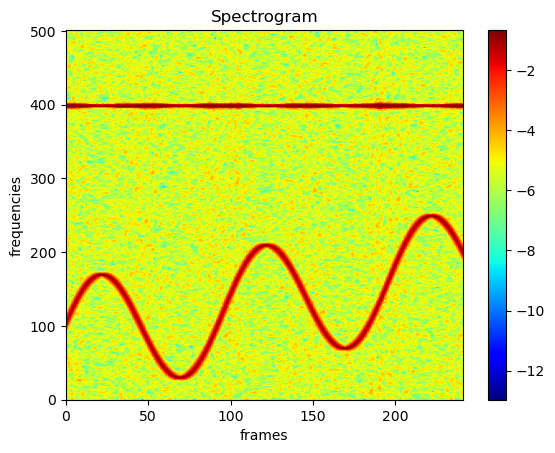

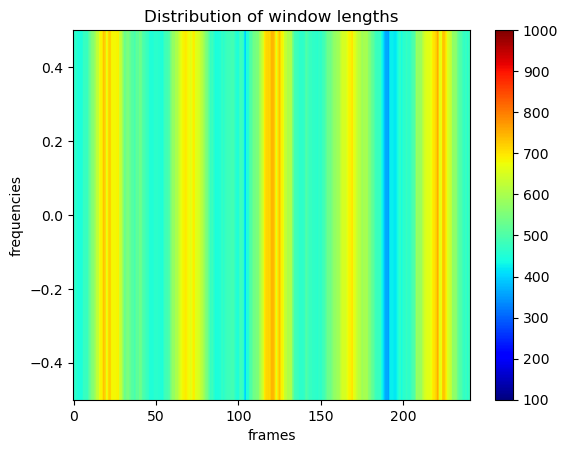

In [11]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


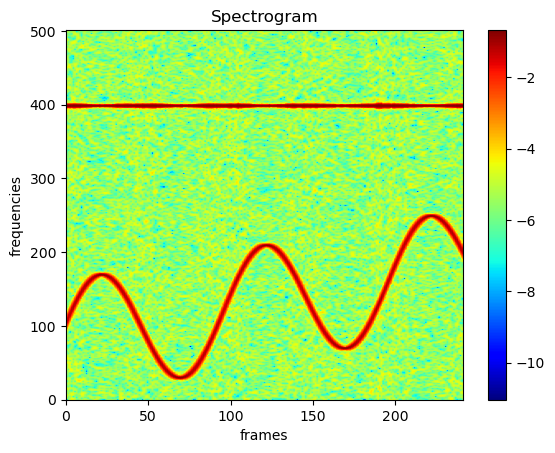

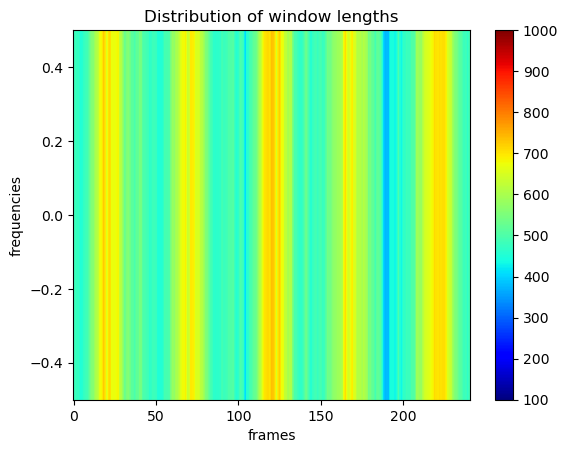

In [12]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.1 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


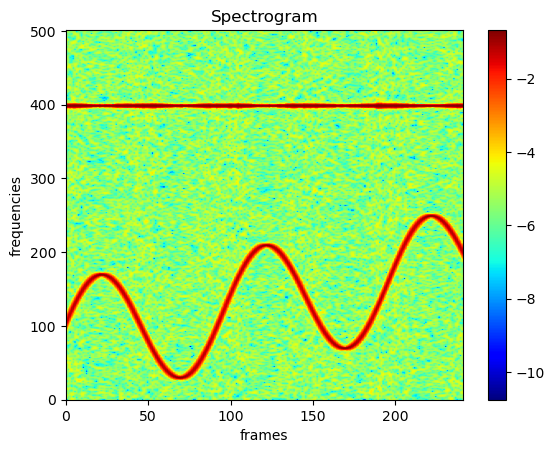

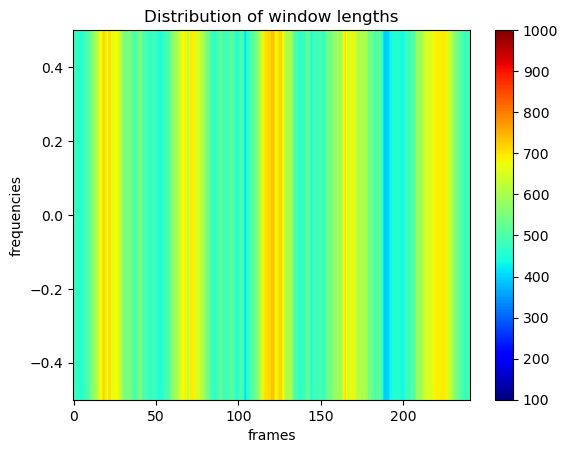

In [13]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 1 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Frequency-varying window length

Epoch 00043: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00061: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00071: reducing learning rate of group 0 to 1.0000e-01.
70


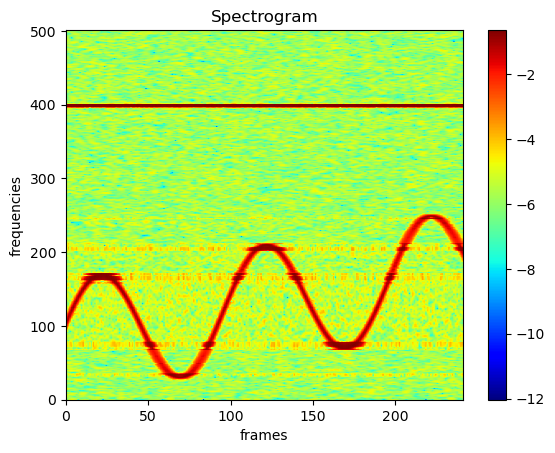

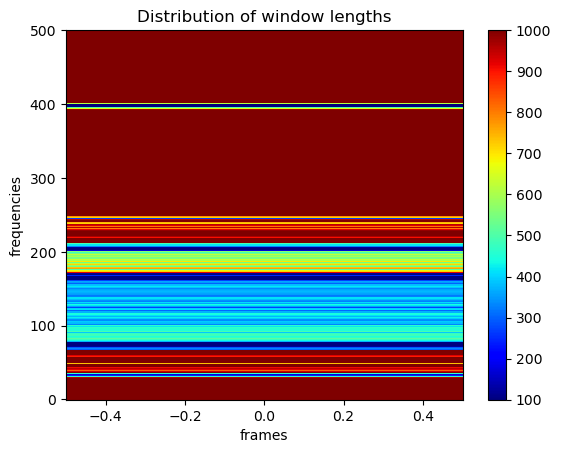

In [14]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)


Epoch 00012: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00157: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00187: reducing learning rate of group 0 to 1.0000e-01.
186


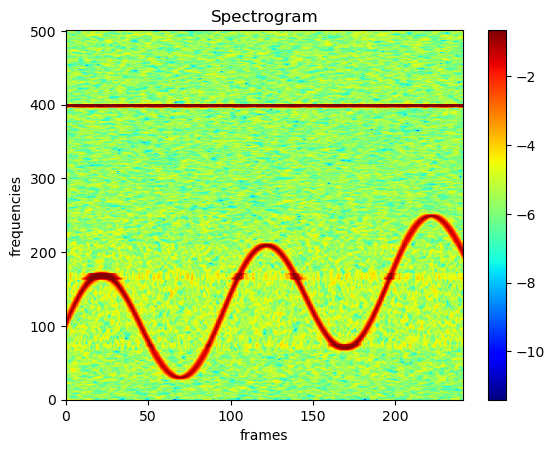

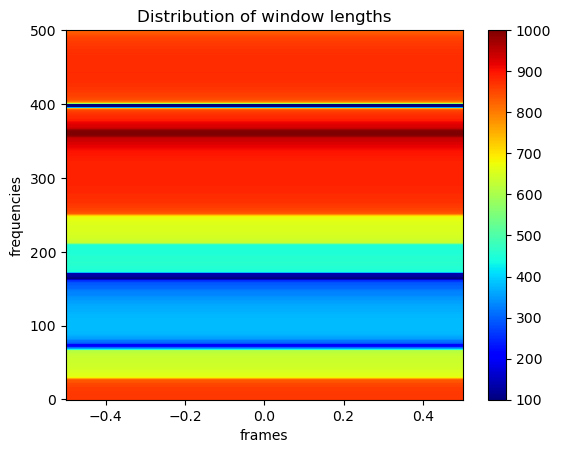

In [9]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.009 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Epoch 00012: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00133: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00156: reducing learning rate of group 0 to 1.0000e-01.
155


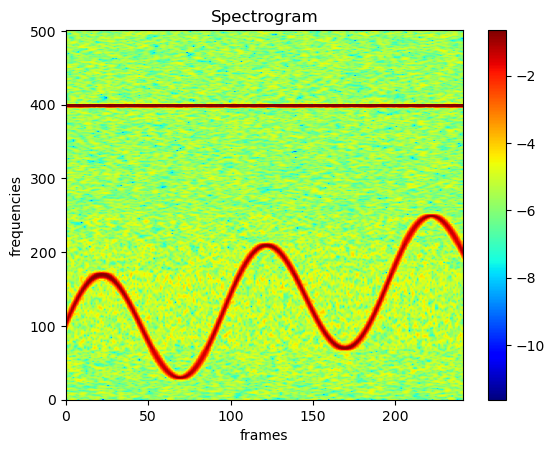

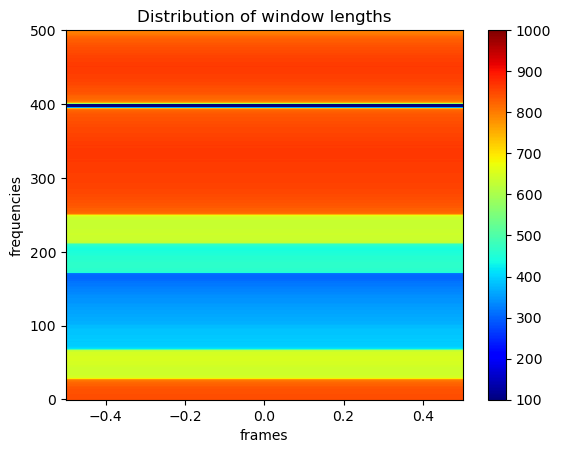

In [16]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


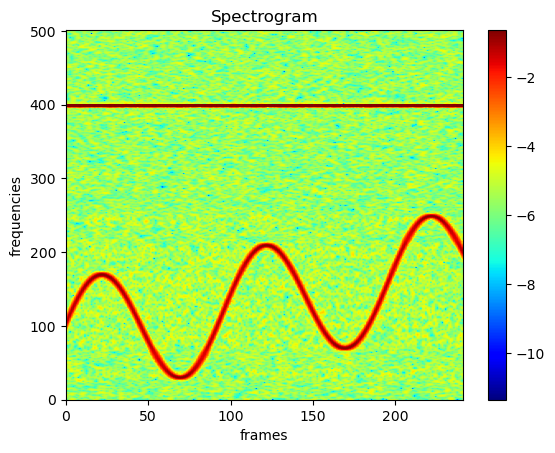

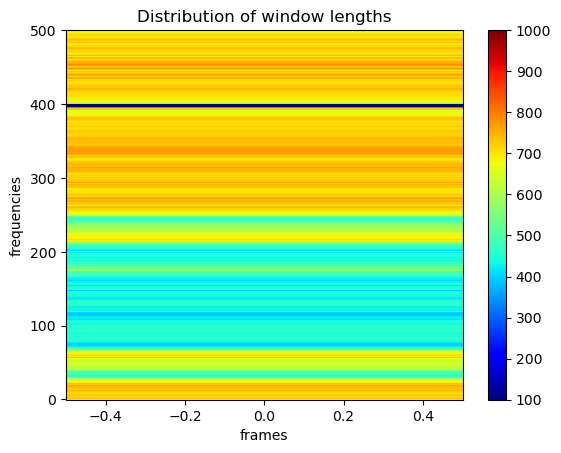

In [17]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.05 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


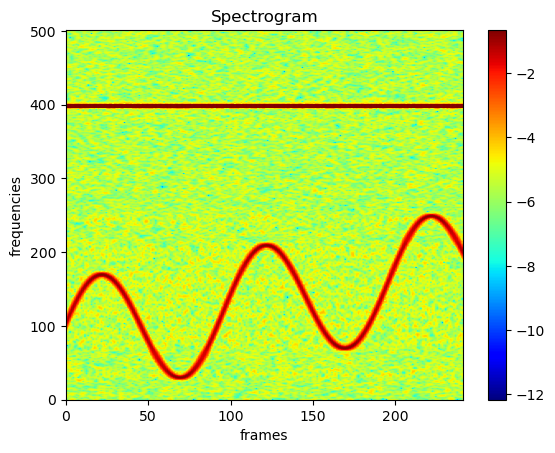

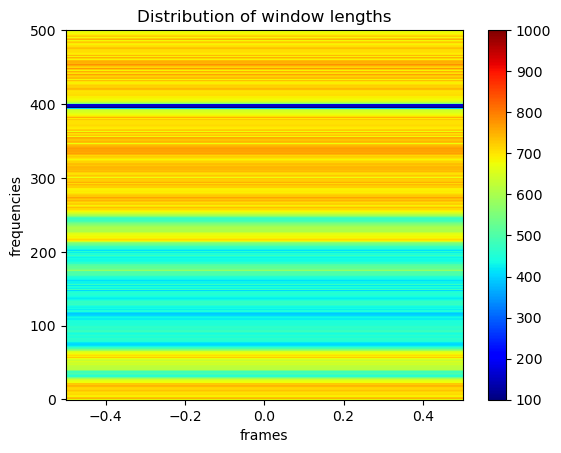

In [18]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.1 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


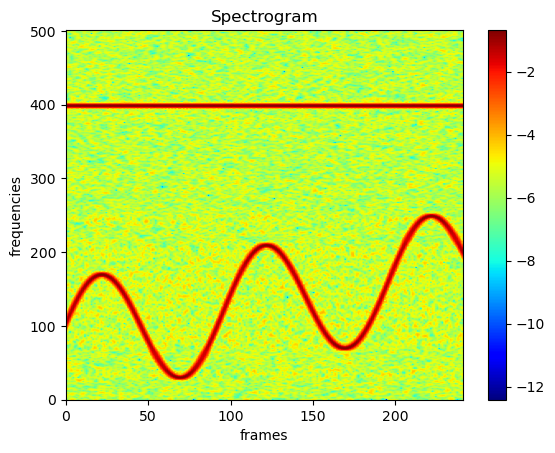

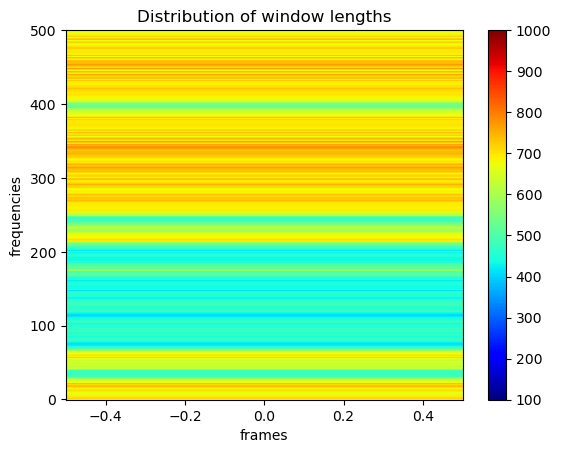

In [19]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 1 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Time-and-frequency-varying window length

Epoch 00054: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00069: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00085: reducing learning rate of group 0 to 1.0000e-01.
84


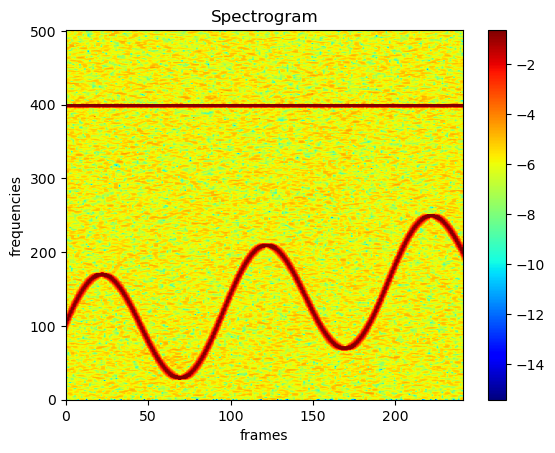

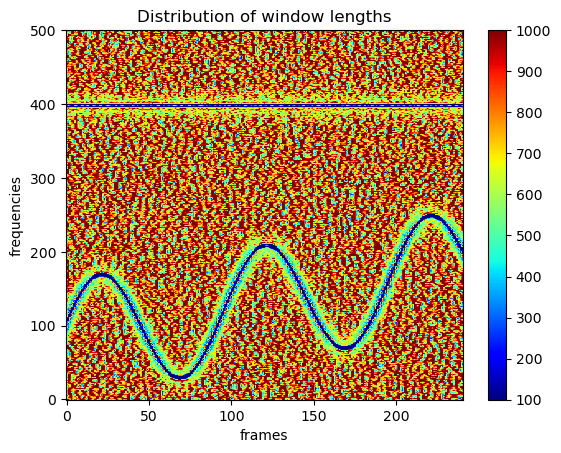

In [3]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00063: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00078: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00092: reducing learning rate of group 0 to 1.0000e-01.
91


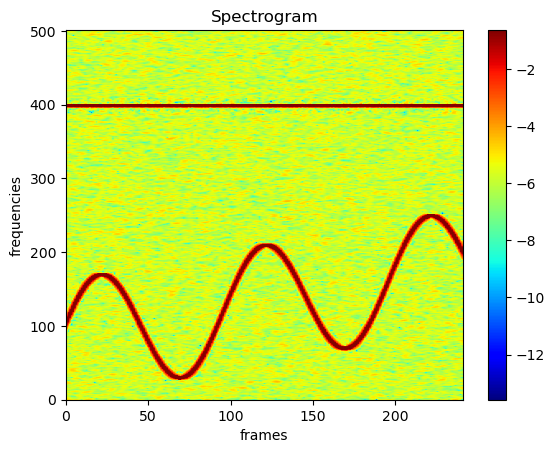

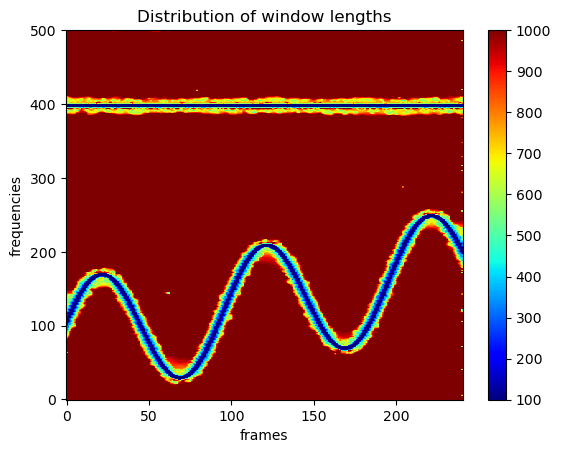

In [6]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.004 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00074: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00105: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00125: reducing learning rate of group 0 to 1.0000e-01.
124


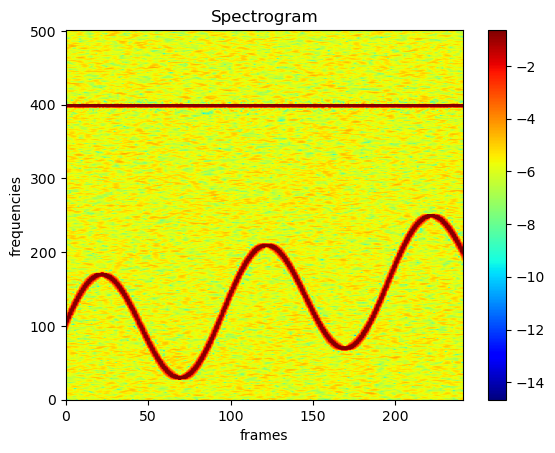

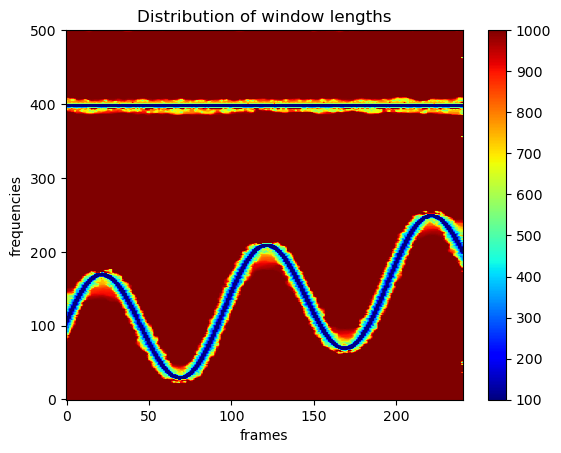

In [10]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.005 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00125: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00171: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00186: reducing learning rate of group 0 to 1.0000e-01.
185


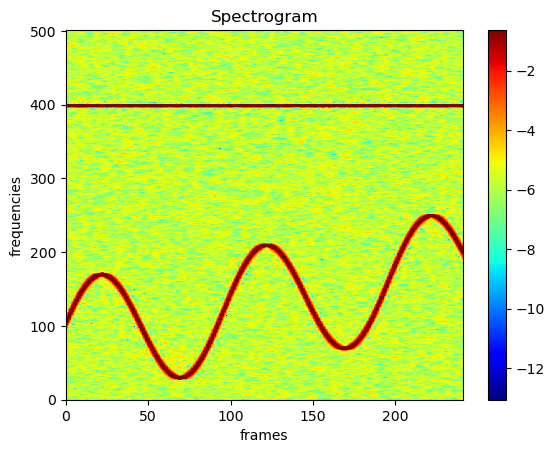

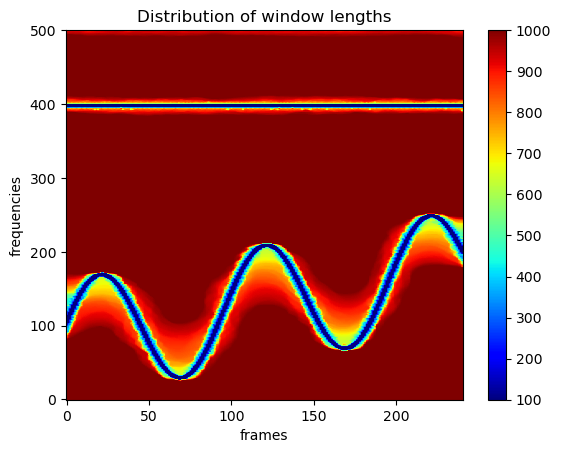

In [5]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00178: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00223: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00253: reducing learning rate of group 0 to 1.0000e-01.
252


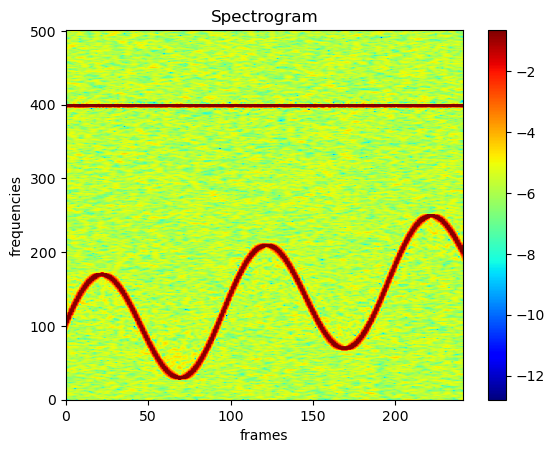

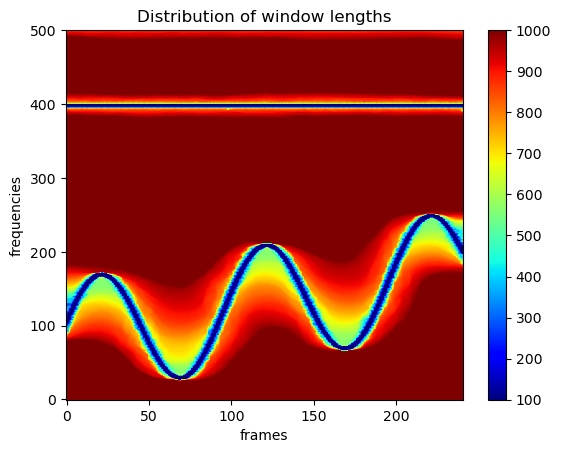

In [6]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.015 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00111: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00176: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00208: reducing learning rate of group 0 to 1.0000e-01.
207


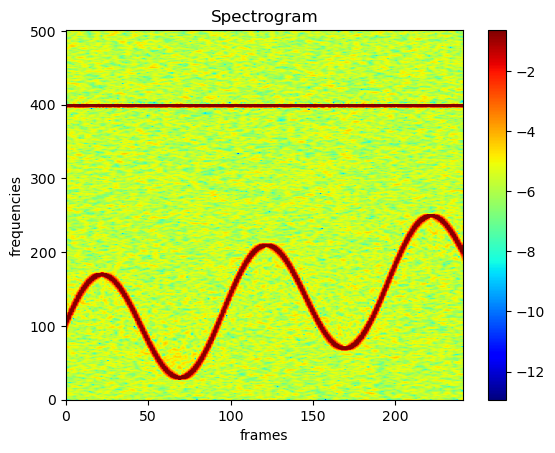

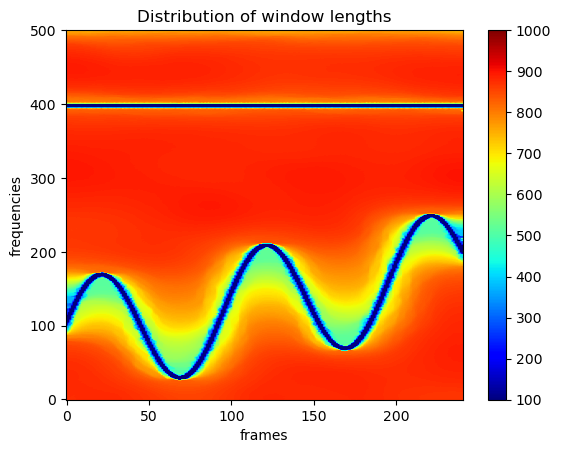

In [7]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.02 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00150: reducing learning rate of group 0 to 1.0000e-01.
149


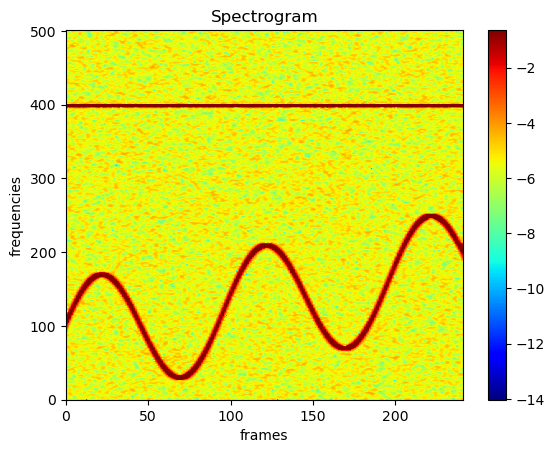

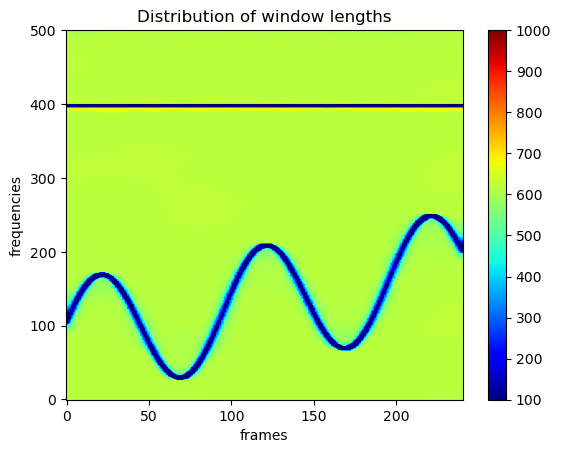

In [8]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.05 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


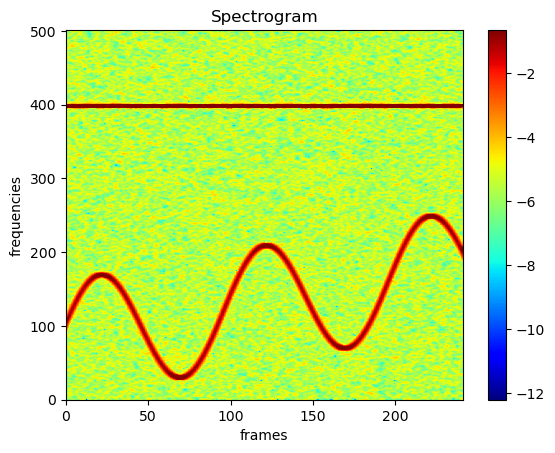

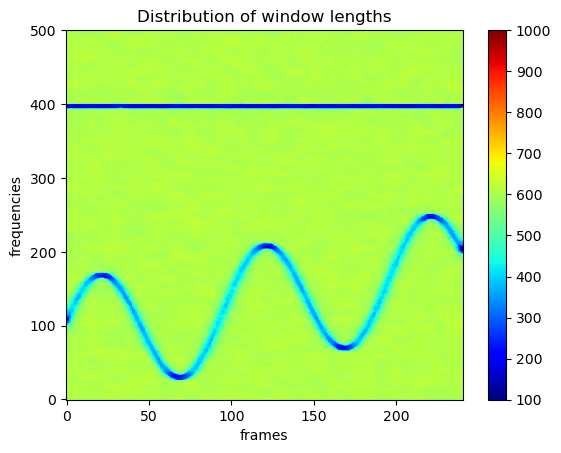

In [9]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.1 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)